In [138]:
import pandas as pd
import numpy as np
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import evaluate
import torch
import os
import requests
import json
import gzip
import zipfile
import matplotlib.pyplot as plt
from google.colab import files
import re

In [171]:
# 1. Load and Preprocess the Dataset
def load_and_preprocess_data(max_samples=3000):
    print("Loading dataset...")
    local_path = "/tmp/code_search_net_python"
    os.makedirs(local_path, exist_ok=True)
    zip_file = os.path.join(local_path, "python.zip")
    data_file = os.path.join(local_path, "python/final/jsonl/train/python_train_0.jsonl.gz")

    if not os.path.exists(data_file):
        print("Downloading CodeSearchNet subset from Zenodo...")
        url = "https://zenodo.org/record/7857872/files/python.zip"
        try:
            response = requests.get(url, stream=True)
            response.raise_for_status()
            with open(zip_file, "wb") as f:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
            print("Download complete.")
            with zipfile.ZipFile(zip_file, "r") as z:
                z.extractall(local_path)
            print("Extraction complete.")
        except Exception as e:
            print(f"Error downloading or extracting dataset: {str(e)}")
            raise Exception("Unable to download dataset. Check connectivity.")

    prompts = []
    codes = []

    def normalize_code(code):
        """Normalize code by removing comments, extra whitespace, and standardizing indentation."""
        code = re.sub(r'#.*?\n', '\n', code)  # Remove comments
        code = re.sub(r'\s+', ' ', code.strip())  # Normalize whitespace
        return code

    try:
        with gzip.open(data_file, "rt", encoding="utf-8") as f:
            for i, line in enumerate(f):
                if i >= max_samples:
                    break
                try:
                    example = json.loads(line.strip())
                    docstring = example.get("docstring", "").strip()
                    code = example.get("code", "").strip()
                    if docstring and code and len(docstring.split()) > 10:  # Ensure meaningful docstrings
                        prompts.append(f"Generate Python code: {docstring}")
                        codes.append(normalize_code(code))
                except json.JSONDecodeError:
                    continue
    except Exception as e:
        print(f"Error processing dataset: {str(e)}")
        raise Exception("Unable to process dataset. Check file integrity.")

    if not prompts:
        raise Exception("No valid docstring-code pairs found in dataset.")

    df = pd.DataFrame({"prompt": prompts, "code": codes})
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    return train_df, val_df.head(100)

In [172]:
# 2. Tokenize the Data
def tokenize_data(train_df, val_df, model_name="t5-base"):
    tokenizer = T5Tokenizer.from_pretrained(model_name)

    def tokenize_batch(examples):
        inputs = tokenizer(
            examples["prompt"], padding="max_length", truncation=True, max_length=128
        )
        targets = tokenizer(
            examples["code"], padding="max_length", truncation=True, max_length=512
        )
        inputs["labels"] = targets["input_ids"]
        return inputs

    from datasets import Dataset
    train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
    val_dataset = Dataset.from_pandas(val_df.reset_index(drop=True))

    train_dataset = train_dataset.map(tokenize_batch, batched=True, batch_size=32)
    val_dataset = val_dataset.map(tokenize_batch, batched=True, batch_size=32)

    return train_dataset, val_dataset, tokenizer

In [173]:
# 3. Fine-Tune the T5 Model
def fine_tune_model(train_dataset, val_dataset, model_name="t5-base"):
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    training_args = TrainingArguments(
        output_dir="/tmp/t5_code_gen",
        num_train_epochs=5,  # Increased for better convergence
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        gradient_accumulation_steps=4,  # Effective batch size of 8
        warmup_steps=100,
        weight_decay=0.01,
        learning_rate=2e-5,
        lr_scheduler_type="cosine",  # Stabilize training
        logging_dir="/tmp/logs",
        logging_steps=25,
        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=1,
        load_best_model_at_end=True,
        fp16=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
    )

    trainer.train()
    torch.cuda.empty_cache()  # Clear GPU memory

    return model, trainer

In [183]:
# 4. Evaluate the Model
def evaluate_model(model, tokenizer, val_df):
    bleu = evaluate.load("bleu")
    model.eval()
    predictions = []
    references = []
    bleu_scores = []

    def normalize_text(text):
        return re.sub(r'\s+', ' ', text.strip())

    for idx, row in val_df.iterrows():
        if not row["prompt"].strip() or not row["code"].strip():
            print(f"Skipping empty sample at index {idx}: prompt='{row['prompt']}', code='{row['code']}'")
            continue

        inputs = tokenizer(
            row["prompt"], return_tensors="pt", padding=True, truncation=True, max_length=128
        ).to(model.device)
        try:
            outputs = model.generate(
                inputs["input_ids"],
                max_length=512,
                num_beams=10,
                top_k=50,
                do_sample=True,  # Enable sampling
                no_repeat_ngram_size=3,  # Increased to avoid repetition
                early_stopping=True,
                length_penalty=1.0
            )
            pred_code = normalize_text(tokenizer.decode(outputs[0], skip_special_tokens=True))
            ref_code = normalize_text(row["code"])

            if not pred_code:
                print(f"Skipping empty prediction at index {idx}: prompt='{row['prompt']}'")
                continue

            predictions.append(pred_code)
            references.append([ref_code])

            try:
                bleu_score = bleu.compute(
                    predictions=[pred_code],
                    references=[[ref_code]],
                    max_order=2,
                    smooth=True
                )
                bleu_scores.append(bleu_score['bleu'])
                if idx < 10:
                    print(f"Sample {idx}:")
                    print(f"  Prompt: {row['prompt']}")
                    print(f"  Prediction: {pred_code}")
                    print(f"  Reference: {ref_code}")
                    print(f"  BLEU: {bleu_score['bleu']}")
            except Exception as e:
                print(f"BLEU computation failed at index {idx}: {str(e)}")
                bleu_scores.append(0.0)
        except Exception as e:
            print(f"Generation failed at index {idx}: {str(e)}")
            continue
        finally:
            torch.cuda.empty_cache()

    try:
        if predictions and references:
            overall_bleu = bleu.compute(
                predictions=predictions,
                references=references,
                max_order=2,
                smooth=True
            )
        else:
            print("No valid predictions/references for overall BLEU computation.")
            overall_bleu = {'bleu': 0.0}
    except Exception as e:
        print(f"Overall BLEU computation failed: {str(e)}")
        overall_bleu = {'bleu': 0.0}

    return overall_bleu, predictions, references, bleu_scores

In [175]:
# 5. Generate Code from a Prompt
def generate_code(model, tokenizer, prompt):
    inputs = tokenizer(
        f"Generate Python code: {prompt}", return_tensors="pt", padding=True, truncation=True, max_length=128
    ).to(model.device)
    outputs = model.generate(
        inputs["input_ids"],
        max_length=512,
        num_beams=10,
        top_k=50,
        top_p=0.9,
        no_repeat_ngram_size=2,
        early_stopping=True,
        length_penalty=1.0
    )
    generated_code = tokenizer.decode(outputs[0], skip_special_tokens=True)
    torch.cuda.empty_cache()
    return generated_code

In [176]:
# 6. Interactive CLI
def interactive_code_generator(model, tokenizer):
    print("Welcome to the T5 Code Generator!")
    print("Enter a prompt (e.g., 'Write a Python function to calculate factorial'). Type 'exit' to quit.")

    while True:
        user_prompt = input("\nEnter your prompt: ")
        if user_prompt.lower() == "exit":
            print("Exiting code generator.")
            break
        if not user_prompt.strip():
            print("Please enter a valid prompt.")
            continue

        try:
            generated_code = generate_code(model, tokenizer, user_prompt)
            print(f"\nGenerated Code:\n{generated_code}")
        except Exception as e:
            print(f"Error generating code: {str(e)}")

In [177]:
# 7. Generate BLEU Score Histogram
def plot_bleu_histogram(bleu_scores):
    plt.hist(bleu_scores, bins=20, color='blue', alpha=0.7)
    plt.xlabel('BLEU Score')
    plt.ylabel('Frequency')
    plt.title('BLEU Score Distribution')
    plt.show()

In [178]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [179]:
# Step 1: Load and preprocess data
print("Loading and preprocessing data...")
train_df, val_df = load_and_preprocess_data(max_samples=4000)

Loading and preprocessing data...
Loading dataset...


In [180]:
# Step 2: Tokenize data
print("Tokenizing data...")
train_dataset, val_dataset, tokenizer = tokenize_data(train_df, val_df)

Tokenizing data...


Map:   0%|          | 0/2194 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [181]:
# Step 3: Fine-tune model
print("Fine-tuning T5 model...")
model, trainer = fine_tune_model(train_dataset, val_dataset)
model.to(device)

Fine-tuning T5 model...


Epoch,Training Loss,Validation Loss
1,1.478800,1.311178
2,1.393400,1.190437
3,1.278900,1.143837
4,1.311000,1.127236
5,1.280000,1.125167


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [184]:
# Step 4: Evaluate model
print("Evaluating model...")
bleu_score, predictions, references, bleu_scores = evaluate_model(model, tokenizer, val_df)
print(f"Overall BLEU Score: {bleu_score['bleu']}")

Evaluating model...
Overall BLEU Score: 0.1150792707075378


Generating BLEU score histogram...


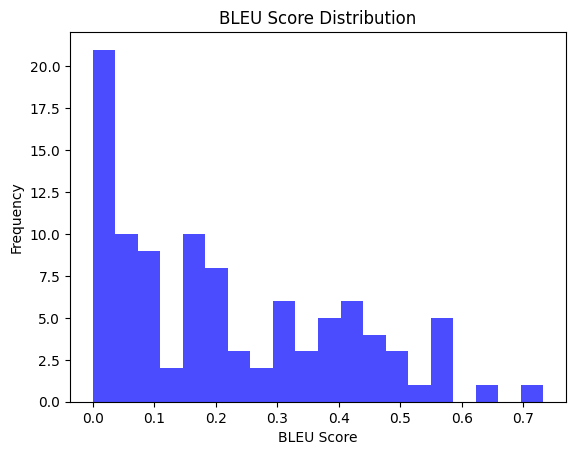

In [185]:
print("Generating BLEU score histogram...")
plot_bleu_histogram(bleu_scores)

In [186]:
print("\nStarting interactive code generator...")
interactive_code_generator(model, tokenizer)


Starting interactive code generator...
Welcome to the T5 Code Generator!
Enter a prompt (e.g., 'Write a Python function to calculate factorial'). Type 'exit' to quit.

Enter your prompt: Write a Python function to calculate factorial


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Generated Code:
def calculate_factorial(self, factororial): """ Write a Python function to calculate factorial" if self.results() is not found: id=0, == 0 - np.frequencies(friq) return ff_factory(Freq=False)

Enter your prompt: Generate Python Code to detect a Prime Number


The following generation flags are not valid and may be ignored: ['top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Generated Code:
def detect_prime_number(self, PrimeNumber): """ Generate Python Code to detect a Prime Number" if self.priority(Principal_Number) is not 0: return Self.PrimaryNUMBER(premium_node)

Enter your prompt: exit
Exiting code generator.
